In [38]:
## load in relevant packages
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import pandas as pd  
import numpy as np
import gpflow
import math as ma
from sklearn.preprocessing import StandardScaler  
feature_scaler = StandardScaler()

np.random.seed(5)

## set max number
N = 100
## set number of sensor locations to find
k = 8
## set percent of N to train on
perc = .10

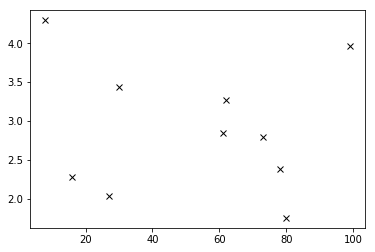

In [39]:
## subset to the trained data
sub = ma.ceil(perc*N)
## create fake data for model
noiseSize = 0.05
#x_train = np.linspace(-3,3,N)
#y_train = np.random.exponential(np.sin(x_train)**2) + np.random.randn(N,1)*noiseSize

## define X values (integers from 0 to N)
X = np.arange(0,N+1,1)
## take sample for training
x_train = np.random.randint(0,N,sub)
x_train = x_train.reshape(-1,1)
x_train = x_train.astype(float)
y_train = np.sin(12*x_train) + 0.66*np.cos(25*x_train)  + np.random.randn(sub,1)*noiseSize + 3

## plot distribution of selected sensors
plt.plot(x_train, y_train, 'kx')

In [40]:
## build model
kernel = gpflow.kernels.RBF(1, active_dims=[0], lengthscales=1.0)
## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## view 
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [41]:
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.673653
  Number of iterations: 19
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.673653
  Number of iterations: 19
  Number of functions evaluations: 22


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                value  
GPR/kern/lengthscales           True   12.249929783108312  
GPR/kern/variance               True   10.752711275527057  
GPR/likelihood/variance         True  0.12279649439486567  


In [42]:
## example: thought exercise
## 5 sensor locations: S = [4,5,6,7,8]
## total number of sensors to find: k = 2
## for each iteration (1:k):
    ## for each possible sensor location (y) not in A (S):
        ## calculate: corr(y)^2 - corr(yA)*np.linalg.inv(corr(AA))*corr(Ay) / corr(y)^2 - corr(ynA)*np.linalg.inv(corr(nAA))*corr(nAy)
    ## select max(store_val)
    ## append y to A

    
## selected sensors (indices)
A = np.array([],dtype=int)
## number of sensors to find
k = k
## define x_new as the new points not used for training
x_new = np.setdiff1d(X, x_train)
x_new = x_new.reshape(-1,1)
## define S as the incides of x_new
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1)    

In [43]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    ## select the 2nd object and bring up one dimension
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:]
    return(cov_mat)

In [44]:
def pick_best_sensors_krause(S, X, k, A, verbose=False):

    ## take out locations already in A before checks
    #S = S[np.isin(S, A, invert=True)]
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    ## add for 2-d, 3-d, etc
    
    ## create definition to generate model
    
    ## later version:
    ## use one full matrix and subset from
    
    ## additional checks:
    ## length of A + k should be less than S
    
    
    ## for each sensor to be added:
    for j in range(k):
        ## find the indices of coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            ## combine indices of y and A
            yA = np.append(np.array([y]), A, axis=0)
            ## collect values of y and A using the indices
            yA_val = X[yA,:].reshape(yA.shape[0],X.shape[1])
            
            ## define the rest of possible sites taking out y and A
            nyA = S[np.isin(S, yA, invert=True)]
            len_nA = nyA.shape[0]
            ## define the indices of locations not in yA
            nyA = np.append(np.array([y]), nyA, axis=0)
            ## collect values of y and nA using the indices
            nyA_val = X[nyA,:].reshape(nyA.shape[0],X.shape[1])

            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA_val)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
            ## grab covariance values
            if len_A > 0:
                AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA_val)
            nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            nAy_cov = nyA_cov.T
            calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            
            value = calc_1 / calc_2
            delta = np.append(delta, value)
            
        ## find the index with the largest delta
        y_star = np.array(Y[np.argmax(delta)])
        ## append to A as a new sensor site
        A = np.append(A, y_star)
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    A_sites = X[A,:]
    return(A_sites)

In [45]:
#def pick_best_sensors_krause(S, k, A, verbose=False):

    ## take out locations already in A before checks
    #S = S[np.isin(S, A, invert=True)]
    
    ## checks
#    if k > S.shape[0]:
#        print("error! k must be smaller than S")
#        return
#    if k/S.shape[0] > 0.25:
#        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
#    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    ## add for 2-d, 3-d, etc
    
    ## create definition to generate model
    
    ## later version:
    ## use one full matrix and subset from
    
    ## additional checks:
    ## length of A + k should be less than S
    
    ## for each sensor to be added:
#    for j in range(k):
        ## find coordinates not already in A to iterate through
#        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
#        delta = np.array([])
        ## print iteration
#        print("Starting iteration: " + str(j))
    
#        for y in Y:
            ## define how many sensor sites already exist
#            len_A = A.shape[0]
            ## place current y in front of A
#            yA = np.append(y,A)
            ## define possible sensor sites not including y & A
#            nyA = S[np.isin(S, yA, invert=True)]
            ## define how many possible sites
#            len_nA = nyA.shape[0]
            ## place current y in front of not y&A
#            nyA = np.append(y,nyA)
            
            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
#            cov_mat_A = generate_cov_mat(yA)
            ## select y's covariance
#            y_cov = cov_mat_A[:1,[0]]
        
            ## grab covariance values
            ## make sure A is not empty
            #print("Determinant: " + str(np.linalg.det(cov_mat_A[1:len_A+1, 1:len_A+1])))
            
#            if len_A > 0:
#                AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
#                yA_cov = cov_mat_A[[0],1:len_A+1]
#                Ay_cov = yA_cov.T
#                calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
#            else:
#                calc_1 = y_cov**2
            
#            cov_mat_nA = generate_cov_mat(nyA)
#            nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
#            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
#            nAy_cov = nyA_cov.T
        
#            calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
#            value = calc_1 / calc_2
#            delta = np.append(delta, value)
            
#        y_star = np.array(Y[np.argmax(delta)])
#        A = np.append(A, y_star)
        
#        if verbose == True:
            #print(Y)
            #print(delta)
#            print("Max value: " + str(np.amax(delta)))
#            print("Picking sensor site: " + str(y_star))
    
#    return(A)

In [46]:
best_sensors = pick_best_sensors_krause(S=S, X=x_new, k=k, A=A, verbose=False)
print(best_sensors)

## OLD
#best_sensors = pick_best_sensors_krause(S=x_new, k=k, A=A, verbose=True)
#best_sensors = best_sensors.reshape(-1,1)
#print(best_sensors)
#added_sensors = best_sensors[np.isin(best_sensors, x_train, invert=True)]

finding 8 sensor locations of 91 possible locations
Starting iteration: 0
Starting iteration: 1
Starting iteration: 2
Starting iteration: 3
Starting iteration: 4
Starting iteration: 5
Starting iteration: 6
Starting iteration: 7
[[57]
 [90]
 [43]
 [ 2]
 [55]
 [38]
 [52]
 [36]]


In [47]:
## plot distribution of sensors
#sns.stripplot
#sns.stripplot(x=x_train, jitter=0.03, color='blue', alpha=0.5)
#sns.stripplot(x=x_new, jitter=0.03, color='green', alpha=0.1)
#sns.stripplot(x=added_sensors, jitter=0.03, color='red', alpha=0.8)

In [48]:
#N = 12
#X = np.random.rand(N,1)
#Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
#print(Y.shape)
#print(X.shape)
#plt.plot(X, Y, 'kx', mew=2)

#k = gpflow.kernels.Matern52(1, lengthscales=0.3)
#m = gpflow.models.GPR(X, Y, kern=k)
#m.likelihood.variance = 0.01
#m.compile()

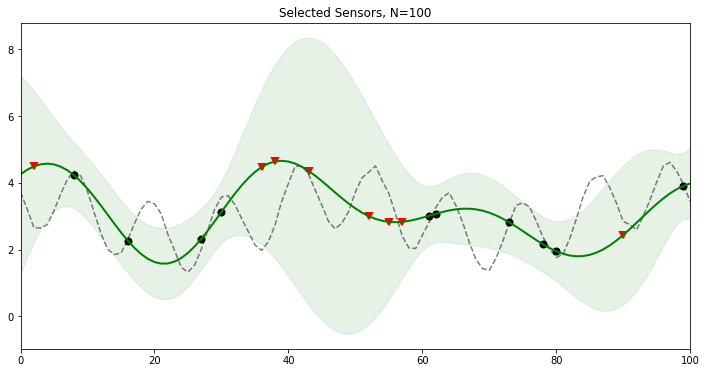

In [49]:
def plot(m):
    ## true underlying function: dashed line
    ## mean: green line
    ## shade: sd
    ## training points: x's
    ## selected sensor points: other shape
    xx = np.linspace(0, N, N+1)[:,None]
    ## actual function
    yy = np.sin(12*xx) + 0.66*np.cos(25*xx)  + np.random.randn(N+1,1)*noiseSize + 3
    ## predict values
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    
    mean_train, var_train = m.predict_y(x_train)
    plt.plot(x_train, mean_train, 'ko', mew=2)
    
    mean_sensors, var_sensors = m.predict_y(best_sensors)
    plt.plot(best_sensors, mean_sensors, 'rv', mew=2)
    
    plt.plot(xx, yy, 'k--', alpha=0.5)
    plt.plot(xx, mean, 'g', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='green', alpha=0.1)
    plt.xlim(0, N)
    plt.title('Selected Sensors, N=' + str(N))
    plt.savefig('../figures/selected_sensors_' + str(N))
plot(m)

In [ ]:
## aggregated over time
dta = pd.read_csv("../data/kcl_london_model_data_winter_agg_time.csv", sep=',')
params = ['latitude', 'longitude']
X = dta[params].values
## rescale lat/long and year data
X = feature_scaler.fit_transform(X)
y = dta.loc[:,'nox'].values
y = y.reshape(-1,1)

In [ ]:
print(X.shape)

In [ ]:
## setting to include the trained sensor points
#include_trained = False
## set max number
N = 50
## set number of sensor locations to find
k = 5
## set percent of N to train on
perc = .10

In [ ]:
## subset to the trained data
sub = ma.ceil(perc*N)
## create fake data for model
noiseSize = 0.05
print(sub)

In [ ]:
## take sample for training
x_train = X[0:sub,:]
print(x_train.shape)
y_train = y[0:sub,:]
print(y_train.shape)

## standardize y-values
y_train = feature_scaler.fit_transform(y_train)

In [ ]:
## build model
kernel = gpflow.kernels.RBF(2, active_dims=[0,1], lengthscales=1.0)

## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## view 
m.as_pandas_table()

In [ ]:
## Run Model
## Marginal Liklihood Maximization
## picks the most simple model that picks the data the best
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

In [ ]:
## define x-values not used for training
x_new = X[sub+1:N+1,:]
print(x_new.shape)
#x_new = x_new.reshape(-1,1)
#print(x_new.shape)

In [ ]:
## possible sensor locations, assign index of locations
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1)
## number of sensors to find
k = k
## selected sensors (indices)
A = np.array([])

In [ ]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:]
    return(cov_mat)

In [ ]:
def pick_best_sensors_krause(S, X, k, A, verbose=False):

    ## take out locations already in A before checks
    #S = S[np.isin(S, A, invert=True)]
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    ## add for 2-d, 3-d, etc
    
    ## create definition to generate model
    
    ## later version:
    ## use one full matrix and subset from
    
    ## additional checks:
    ## length of A + k should be less than S
    
    
    ## for each sensor to be added:
    for j in range(k):
        ## find the indices of coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            ## combine indices of y and A
            yA = np.append(np.array([y]), A, axis=0)
            ## collect values of y and A using the indices
            yA_val = X[yA,:].reshape(yA.shape[0],X.shape[1])
            
            ## define the rest of possible sites taking out y and A
            nyA = S[np.isin(S, yA, invert=True)]
            len_nA = nyA.shape[0]
            ## define the indices of locations not in yA
            nyA = np.append(np.array([y]), nyA, axis=0)
            ## collect values of y and nA using the indices
            nyA_val = X[nyA,:].reshape(nyA.shape[0],X.shape[1])

            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA_val)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
            ## grab covariance values
            if len_A > 0:
                AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA_val)
            nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            nAy_cov = nyA_cov.T
            calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            
            value = calc_1 / calc_2
            delta = np.append(delta, value)
            
        ## find the index with the largest delta
        y_star = np.array(Y[np.argmax(delta)])
        ## append to A as a new sensor site
        A = np.append(A, y_star)
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    A_sites = X[A,:]
    return(A_sites)

In [ ]:
x_new = X[sub+1:N+1,:]
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1)
best_sensors = pick_best_sensors_krause(S=S, X=X, k=k, A=A, verbose=False)
print(best_sensors)